# A tutorial in torchAttacks (Adversarial attacks)
Here I have followed the following [example](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118) for a convolution neural network.

However I followed this [tutorial](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html) for the adversarial attack stuff.

## Import.STONKS()

And also defining where to put the model weights

In [51]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
from PIL import Image
from torch.autograd import Variable
%matplotlib inline




## Inputs

We apparently only need two inputs for this attack. They are:

- **Epsilons** A list of epsilon values in the range [0,1]. Importantly 0 has to be kept in the list as it has to represent the model performance on the original test set.
- **use_cuda** Just a boolean to tell the model to use a GPU if available (which it isn't on this computer...)

In [4]:
epsilons = torch.linspace(0, 0.05, 6)
eps_setp_size = epsilons[1].item()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


## Downloading data

Downloading photo from internet!

Directory already exists.


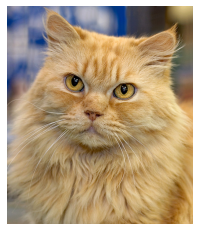

In [5]:
def download(url,fname):
    response = requests.get(url)
    with open(fname,"wb") as f:
        f.write(response.content)

# path for the downloaded images
imagePath = "../data/downloaded_pics/input.jpg"
imageDirectory = "../data/downloaded_pics/"

# Check whether the directory exists
if not os.path.exists(imageDirectory):
        os.mkdir(imageDirectory)
        print("A new directory 'downloaded_pics' was created under 'data'.")
else:
        print("Directory already exists.")
             
# Downloading the image    
download(
        "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02123394_Persian_cat.JPEG",
        imagePath)

# Opening the image
img = Image.open(imagePath) 

plt.axis('off')
plt.imshow(np.asarray(img))


In [111]:
def preprocess(image, size=224):
    transform = transforms.Compose([
        #transforms.Resize((size,size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Lambda(lambda x: x[None]),
    ])
    return transform(image)

def deprocess(image):
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x[0]),
        transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        #transforms.ToPILImage(),
    ])
    return transform(image)


## Model under attack

The model obviously also needs to be defined:

In [7]:
#Using VGG-19 pretrained model for image classification
model = models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False


## Defining loss and optimization function

Both the loss function and the optimization function needs to be defined for this particular neural network.
They are defined as follows.

(Why it is always that CrossEntropyLoss.. I do not know)

In [8]:
lrn_rt = 0.5e-3

loss_fn = nn.CrossEntropyLoss()

# We are just going to use Adam, because it has proven to be effective.
optimizer = optim.Adam(model.parameters(), lr=lrn_rt)

## FGSM Attack
(Fast Gradient Sign Method) Attack.
Here we define the function that creates the adversarial example by urbing the original image.

In [9]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad, add_noise = False):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    if add_noise:
        noise = epsilon*sign_data_grad
        return perturbed_image, noise
    else:
        # Return the perturbed image
        return perturbed_image

## For a random Image perform attack
A function for performing the FGSM (Fast Gradient Sign Method) attack and creating a saliency map of the original image.

My solution to this was doing both the saliency map and the adversarial attack, each on their own, instead of serialising it, seeing as how they use a lot of the same functions.
This was with the intend of not showing unnecessary correlation, but I might have been overthinking it.

In [148]:
def advAtkSingleImage(model, device, epsilon,img):
    # N = len(testset)
    # if target_indx is None:
    #     np.random.randint(low=0, high=N)
    # if target_indx > N:
    #     errorString = "The target index you picked is greater than the number of pictures..."
    #     raise Exception(errorString)
    
    # convoluted_index = (target_indx - 1) % batch_size
    
    # # NOTE: if looking at this again, try seeing the islice function.
    # # This is not smart...
    # dataiter = iter(test_loader)
    # for _ in range(target_indx//batch_size - 1):
    #     dataiter.next()

    
    # data, target = dataiter.next()

    # Send the data and label to the device
    #data, target = data.to(device), target.to(device)

    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True

    # Forward pass the data through the model
    output = model(data)
    
    _, init_pred_index = output.max(1, keepdim=True) # get the index of the max log-probability
    
    target = output.argmax()

    # Calculate the loss
    loss = torch.nn.CrossEntropyLoss()(output, target)

    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect datagrad
    data_grad = data.grad.data
    
    # Call FGSM Attack
    perturbed_data, noise = fgsm_attack(data, epsilon, data_grad, add_noise=True)
    
    # Re-classify the perturbed image
    output = model(perturbed_data)
    
    # Check for success
    _, final_pred_index = output.max(1, keepdim=True) # get the index of the max log-probability
    
    # (Hopefully) the five things I need
    adv_ex = np.transpose(perturbed_data.detach(), (1, 2, 0))
    adv_pred_label = target.detach()
    adv_attack_label = final_pred_index.detach()
    orig_image = np.transpose(data.detach(), (1, 2, 0))
    noise = np.transpose(noise.detach(), (1, 2, 0)).abs()
    #inverted_noise = torch.ones(noise.size()) - noise
    
    return orig_image, adv_ex, adv_pred_label, adv_attack_label, noise
 
    
def saliencyMapSingleImage(model, data):
    
    data.requires_grad_()

    # we would run the model in evaluation mode
    model.eval()
    # Zero all existing gradients
    model.zero_grad()
    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True
    
    # Get the index corresponding to the maximum score and the maximum score itself.
    scores = model(data)
    
    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]
    
    # backward function on score_max performs the backward pass in the computation
    # graph and calculates the gradient of score_max with respect to nodes in the
    # computation graph
    score_max.backward()
    
    # Saliency would be the gradient with respect to the input image now. But note
    # that the input image has 3 channels, R, G and B. To derive a single class
    # saliency value for each pixel (i, j),  we take the maximum magnitude
    # across all colour channels.
    saliency_mean_abs = torch.mean(data.grad.data.abs(), dim=1) #torch.max(X.grad.data.abs(),dim=1)
    saliency_max_abs, _ = torch.max(data.grad.data.abs(), dim=1)

    return saliency_max_abs, saliency_mean_abs



In [192]:
data = preprocess(img)
epsilon = 0.5

img_variable = Variable(data, requires_grad=True)


output = model(img_variable)
label_idx = torch.max(output.data, 1)[1][0]   #get an index(class number) of a largest element
#print(label_idx)

labels_link = "https://savan77.github.io/blog/labels.json"    
labels_json = requests.get(labels_link).json()
labels = {int(idx):label for idx, label in labels_json.items()}
x_pred = labels[label_idx.item()]
#print(x_pred)

#get probability dist over classes
output_probs = F.softmax(output, dim=1)
x_pred_prob =  (torch.max(output_probs.data, 1)[0][0]) * 100
#print(x_pred_prob.item())

target = Variable(torch.LongTensor([label_idx.item()]), requires_grad=False)

model.zero_grad()

#perform a backward pass in order to get gradients
loss = torch.nn.CrossEntropyLoss()
loss_cal = loss(output, target)
loss_cal.backward(retain_graph=True)    #this will calculate gradient of each variable (with requires_grad=True) and can be accessed by "var.grad.data"

data_grad = img_variable.grad.data
    
# Call FGSM Attack
perturbed_data, noise = fgsm_attack(data, epsilon, data_grad, add_noise=True)
    
# Re-classify the perturbed image
output = model(perturbed_data)

_, final_pred_index = output.max(1, keepdim=True) # get the index of the max log-probability


adv_ex = np.transpose(deprocess(perturbed_data.detach()), (1, 2, 0)) 
adv_pred_label = target.detach()
adv_attack_label = final_pred_index.detach()
#orig_image = np.transpose(img_variable.detach(), (1, 2, 0))
noise = np.transpose(deprocess(noise.detach()), (1, 2, 0)) #np.transpose(noise.detach(), (1, 2, 0)).abs()
print(labels[adv_pred_label.item()])
#plt.axis('off')
#plt.imshow(deprocess(data[0]))
orig_image = np.transpose(deprocess(img_variable.detach()),(1,2,0))
#orig_image = deprocess(np.transpose(data.detach(), (1,2,0)))



Persian cat


In [196]:
NOISE = torch.mean(noise.abs(), dim=2)

NOISE_scale = (NOISE - NOISE.min()) /(NOISE.max()-NOISE.min() )

print(NOISE.size())

torch.Size([500, 426])


# The plotting!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Persian cat


Text(0.5, 1.0, 'The max saliency map')

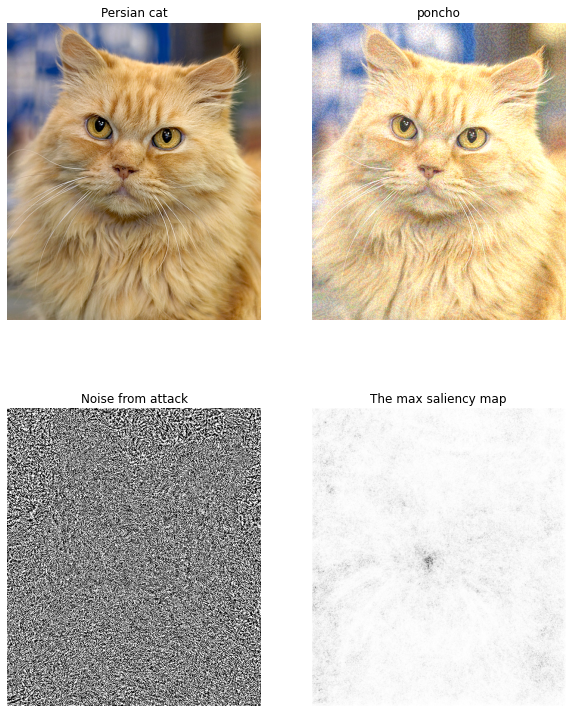

In [197]:
# Saliency stuff
saliency_max_abs, saliency_mean_abs = saliencyMapSingleImage(model, data)
print(labels[adv_pred_label.item()])

fig, axes = plt.subplots(2,2, figsize= (10, 13))
axes[0,0].imshow(orig_image)
axes[0,0].axis("off")
axes[0,0].set_title(f"{labels[adv_pred_label.item()]}")

axes[0,1].imshow(orig_image + epsilon*noise)
axes[0,1].axis("off")
axes[0,1].set_title(f"{labels[adv_attack_label.item()]}")

axes[1,0].imshow(NOISE_scale, cmap='gray')
axes[1,0].axis("off")
axes[1,0].set_title("Noise from attack")

axes[1,1].imshow(saliency_max_abs[0].max() - saliency_max_abs[0], cmap='gray')
axes[1,1].axis("off")
axes[1,1].set_title("The max saliency map")

### The plotting
Actually plotting all that we found found

In [137]:
# Preprocess of input image
data = preprocess(img)
epsilon = 0.05

print(data.size())
saliency_max_abs, saliency_mean_abs = saliencyMapSingleImage(model, data)
orig_image, adv_ex, adv_pred_label, adv_attack_label, noise = advAtkSingleImage(model, device, epsilon, data)

plt.subplot(1,2,1)
plt.imshow(saliency_mean_abs[0].max() -saliency_mean_abs[0], cmap='gray')
plt.axis('off')
plt.title('Saliency map mean')

plt.subplot(1,2,2)
plt.imshow(saliency_max_abs[0].max() - saliency_max_abs[0], cmap='gray')
plt.axis('off')
plt.title('Saliency map max')


torch.Size([1, 3, 500, 426])
tensor(283)


IndexError: dimension specified as 0 but tensor has no dimensions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'The max saliency map')

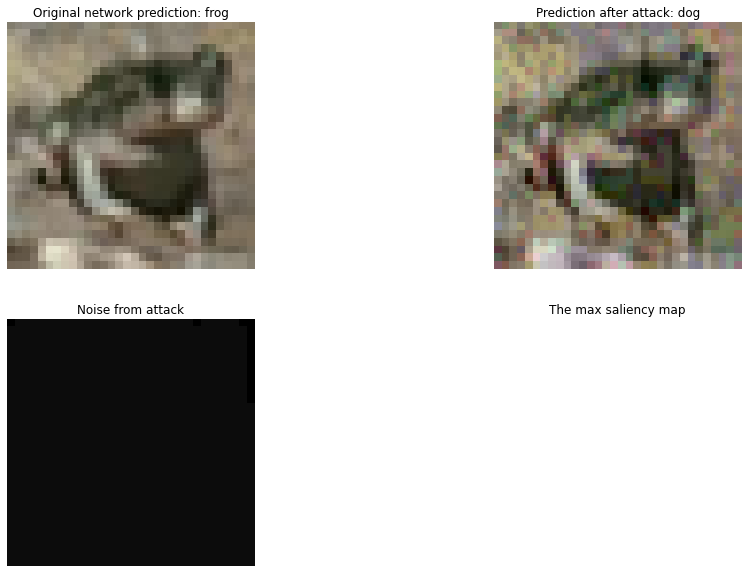

In [23]:
# Pick target index & epsilon in [0,1]
epsilon = 0.05
target_index = 69


orig_image, adv_ex, adv_pred_label, adv_attack_label, noise = advAtkSingleImage(
    model, device, testloader, batch_size, epsilon=epsilon, target_indx=target_index
    )
saliency_max_abs, saliency_mean_abs = saliencyMapSingleImage(model, testloader, batch_size, target_indx=target_index)


# If changed to false, mean will instead be plotted
plot_max_saliency_map = True

if plot_max_saliency_map:
    image_to_be_shown = saliency_max_abs
    salMap_Text = "max"
else:
    image_to_be_shown = saliency_mean_abs
    salMap_Text = "mean"

fig, axes = plt.subplots(2,2, figsize= (16, 10))
axes[0,0].imshow(orig_image)
axes[0,0].axis("off")
axes[0,0].set_title(f"Original network prediction: {classes[adv_pred_label]}")

axes[0,1].imshow(adv_ex)
axes[0,1].axis("off")
axes[0,1].set_title(f"Prediction after attack: {classes[adv_attack_label]}")

axes[1,0].imshow(noise)
axes[1,0].axis("off")
axes[1,0].set_title("Noise from attack")

axes[1,1].imshow(image_to_be_shown)
axes[1,1].axis("off")
axes[1,1].set_title("The " + salMap_Text + " saliency map")

